# ManoMano Data Science test

In [267]:
import pandas as pd
import numpy as np
import unicodedata
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import time, math
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

### Import Data

convert all strings to lowercase and remove all accents, remove spaces

In [231]:
train_df = pd.read_csv('drugs_train.csv')
test_df = pd.read_csv('drugs_test.csv')

In [232]:
# convert all strings to lowercase and remove all accents, remove spaces
for i in list(train_df.select_dtypes(include=['object'])):
    #convert all strings to lowercase and remove all accents
    train_df[i] = train_df[i].str.lower().map(lambda x: unicodedata.normalize('NFKD', x))#.encode('ASCII', 'ignore'))
    test_df[i] = test_df[i].str.lower().map(lambda x: unicodedata.normalize('NFKD', x))#.encode('ASCII', 'ignore'))
    #removes space if it is first character
    train_df[i] = train_df[i].apply(lambda x : x[1:] if x[0]==' ' else x)    
    test_df[i] = test_df[i].apply(lambda x : x[1:] if x[0]==' ' else x)

# convert column name from string to unicode
#train_df.rename(columns=lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'), inplace=True)
#test_df.rename(columns=lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore'), inplace=True)

In [233]:
train_df.head()

,drug_id,description,administrative_status,marketing_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_authorization_status,marketing_declaration_date,marketing_authorization_date,marketing_authorization_process,pharmaceutical_companies,price
0,0_train,3 plaquette(s) thermoformée(s) pvc-aluminium ...,présentation active,déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,autorisation active,20140101,20140101,procédure décentralisée,majorelle luxembourg soparfi (luxembourg),2.83
1,1_train,plaquette(s) thermoformée(s) aluminium de 28 ...,présentation active,déclaration de commercialisation,oui,65%,comprimé à croquer,orale,autorisation active,20130101,20090101,procédure de reconnaissance mutuelle,teva sante,14.30
2,2_train,plaquette(s) thermoformée(s) pvc-aluminium de...,présentation active,déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,autorisation active,20000101,19960101,procédure nationale,mylan sas,5.66
3,3_train,30 sachet(s)-dose(s) papier aluminium complexe...,présentation active,déclaration de commercialisation,oui,65%,granulés à libération prolongée,orale,autorisation active,20050101,20040101,procédure nationale,sanofi aventis france,24.27
4,4_train,plaquette(s) thermoformée(s) pvc-aluminium de...,présentation active,déclaration d'arrêt de commercialisation,non,100%,comprimé pelliculé,orale,autorisation active,20150101,20100101,procédure nationale,teva sante,59.94


### Descriptive analysis

### I. Data Distribution

#### I.1 Price

In [234]:
feat_num = ['price', 'logprice']

<AxesSubplot:>

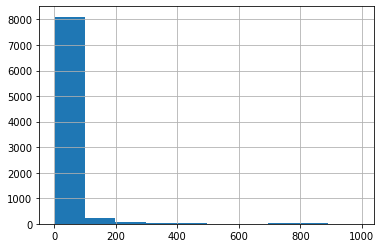

In [235]:
train_df['price'].hist()

On prend le log des prix car sa distribution transformée est plus proche d'une gaussienne

count    8564.000000
mean        2.279071
std         1.271988
min        -0.510826
25%         1.371181
50%         2.071913
75%         3.002211
max         6.898099
Name: logprice, dtype: float64


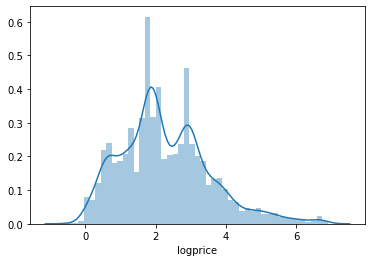

In [236]:
# Distribution du log des prix
train_df['logprice'] = train_df['price'].apply(np.log)
#train['logprix'].hist()
sns.distplot(train_df['logprice'])
print(train_df['logprice'].describe())

La distribution du prix en log est bimodale: un pic principal a environ exp(1.8)=6 euros et un pic secondaire a environ exp(2.9)=18 euros.
La moyenne de prix log est 2.27 et l'ecart type est 1.27.

#### I. 2 Feature engineering

In [237]:
def rstr(df):
    # useful to find unique values of categorical variables
    return df.shape, df.apply(lambda x: [len(x.unique()), x.unique()])   

rstr(train_df.append(test_df))

((12235, 15),
 drug_id                            [12235, [0_train, 1_train, 2_train, 3_train, 4...
 description                        [3145, [3 plaquette(s) thermoformée(s) pvc-al...
 administrative_status              [2, [présentation active, présentation abrog...
 marketing_status                   [4, [déclaration de commercialisation, décla...
 approved_for_hospital_use                                            [2, [oui, non]]
 reimbursement_rate                                    [5, [65%, 100%, 15%, 30%, 0%]]
 dosage_form                        [218, [comprimé pelliculé, comprimé à croq...
 route_of_administration            [78, [orale, transdermique, inhalée, orale,va...
 marketing_authorization_status     [5, [autorisation active, autorisation abrogé...
 marketing_declaration_date         [84, [20140101, 20130101, 20000101, 20050101, ...
 marketing_authorization_date       [40, [20140101, 20090101, 19960101, 20040101, ...
 marketing_authorization_process    [5, 

***Dates***

In [238]:
# TRAINING SET
train_df['marketing_declaration_date'] = train_df['marketing_declaration_date'].apply(lambda x: str(x)[:4]).astype(int)
train_df['marketing_authorization_date'] = train_df['marketing_authorization_date'].apply(lambda x: str(x)[:4]).astype(int)

# TEST SET
test_df['marketing_declaration_date'] = test_df['marketing_declaration_date'].apply(lambda x: str(x)[:4]).astype(int)
test_df['marketing_authorization_date'] = test_df['marketing_authorization_date'].apply(lambda x: str(x)[:4]).astype(int)

**drug_id**

No need --> Bias

In [239]:
train_df = train_df.drop(['drug_id'], axis=1)
test_df = test_df.drop(['drug_id'], axis=1)

**Binary variables**

Administrative status - Approved for hospital use

In [240]:
replace_dict = {'présentation abrogée': 0, 'présentation active': 1,
                'non': 0, 'oui': 1,
               }
feat_binary = ['approved_for_hospital_use', 'administrative_status']

for column in feat_binary:
    train_df.loc[:, column] = train_df.loc[:, column].replace(replace_dict)
    test_df.loc[:, column] = test_df.loc[:, column].replace(replace_dict)
    
train_df.head()

,description,administrative_status,marketing_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_authorization_status,marketing_declaration_date,marketing_authorization_date,marketing_authorization_process,pharmaceutical_companies,price,logprice
0,3 plaquette(s) thermoformée(s) pvc-aluminium ...,1,déclaration de commercialisation,1,65%,comprimé pelliculé,orale,autorisation active,2014,2014,procédure décentralisée,majorelle luxembourg soparfi (luxembourg),2.83,1.040277
1,plaquette(s) thermoformée(s) aluminium de 28 ...,1,déclaration de commercialisation,1,65%,comprimé à croquer,orale,autorisation active,2013,2009,procédure de reconnaissance mutuelle,teva sante,14.30,2.660260
2,plaquette(s) thermoformée(s) pvc-aluminium de...,1,déclaration de commercialisation,1,65%,gélule à libération prolongée,orale,autorisation active,2000,1996,procédure nationale,mylan sas,5.66,1.733424
3,30 sachet(s)-dose(s) papier aluminium complexe...,1,déclaration de commercialisation,1,65%,granulés à libération prolongée,orale,autorisation active,2005,2004,procédure nationale,sanofi aventis france,24.27,3.189241
4,plaquette(s) thermoformée(s) pvc-aluminium de...,1,déclaration d'arrêt de commercialisation,0,100%,comprimé pelliculé,orale,autorisation active,2015,2010,procédure nationale,teva sante,59.94,4.093344


**Categorical variables**

In [242]:
feat_categorical = ['marketing_authorization_status', 'marketing_authorization_process', 'marketing_status']

In [244]:
def one_hot_dataframe(data_train, data_test, cols, replace=False):
    vec = DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    data_tot = data_train.append(data_test)
    vec.fit(data_tot[cols].apply(mkdict, axis=1))   # fit on both train and test
    # on train
    vecData_train = pd.DataFrame(vec.transform(data_train[cols].apply(mkdict, axis=1)).toarray()).astype(int)
    vecData_train.columns = vec.get_feature_names()
    vecData_train.index = data_train.index
    # on test
    vecData_test = pd.DataFrame(vec.transform(data_test[cols].apply(mkdict, axis=1)).toarray()).astype(int)
    vecData_test.columns = vec.get_feature_names()
    vecData_test.index = data_test.index
    if replace is True:
        data_train = data_train.drop(cols, axis=1)
        data_train = data_train.join(vecData_train)
        data_test = data_test.drop(cols, axis=1)
        data_test = data_test.join(vecData_test)
    return data_train, data_test, list(vecData_train)

train_df, test_df, feat_cat = one_hot_dataframe(train_df, test_df, feat_categorical, replace=True)

In [245]:
train_df.head()

,description,administrative_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_declaration_date,marketing_authorization_date,pharmaceutical_companies,price,...,marketing_authorization_process=procédure nationale,marketing_authorization_status=autorisation abrogée,marketing_authorization_status=autorisation active,marketing_authorization_status=autorisation archivée,marketing_authorization_status=autorisation retirée,marketing_authorization_status=autorisation suspendue,marketing_status=arrêt de commercialisation (le médicament n'a plus d'autorisation),marketing_status=déclaration d'arrêt de commercialisation,marketing_status=déclaration de commercialisation,marketing_status=déclaration de suspension de commercialisation
0,3 plaquette(s) thermoformée(s) pvc-aluminium ...,1,1,65%,comprimé pelliculé,orale,2014,2014,majorelle luxembourg soparfi (luxembourg),2.83,...,0,0,1,0,0,0,0,0,1,0
1,plaquette(s) thermoformée(s) aluminium de 28 ...,1,1,65%,comprimé à croquer,orale,2013,2009,teva sante,14.30,...,0,0,1,0,0,0,0,0,1,0
2,plaquette(s) thermoformée(s) pvc-aluminium de...,1,1,65%,gélule à libération prolongée,orale,2000,1996,mylan sas,5.66,...,1,0,1,0,0,0,0,0,1,0
3,30 sachet(s)-dose(s) papier aluminium complexe...,1,1,65%,granulés à libération prolongée,orale,2005,2004,sanofi aventis france,24.27,...,1,0,1,0,0,0,0,0,1,0
4,plaquette(s) thermoformée(s) pvc-aluminium de...,1,0,100%,comprimé pelliculé,orale,2015,2010,teva sante,59.94,...,1,0,1,0,0,0,0,1,0,0


**Ordinal variables**

<AxesSubplot:xlabel='reimbursement_rate', ylabel='count'>

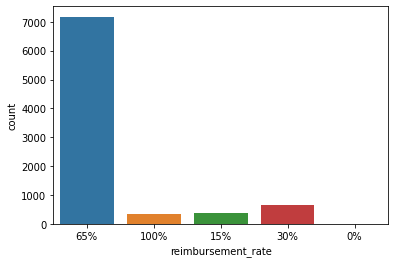

In [246]:
feat_ordinal = ["reimbursement_rate"]

sns.countplot(x="reimbursement_rate", data=train_df)

In [247]:
rates = train_df['reimbursement_rate'].unique()
replace_dict = {i: j for i, j in zip(rates, range(len(rates), 0, -1))}

for column in feat_ordinal:
    train_df.loc[:, column] = train_df.loc[:, column].replace(replace_dict)
    test_df.loc[:, column] = test_df.loc[:, column].replace(replace_dict)

In [248]:
train_df.head()

,description,administrative_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_declaration_date,marketing_authorization_date,pharmaceutical_companies,price,...,marketing_authorization_process=procédure nationale,marketing_authorization_status=autorisation abrogée,marketing_authorization_status=autorisation active,marketing_authorization_status=autorisation archivée,marketing_authorization_status=autorisation retirée,marketing_authorization_status=autorisation suspendue,marketing_status=arrêt de commercialisation (le médicament n'a plus d'autorisation),marketing_status=déclaration d'arrêt de commercialisation,marketing_status=déclaration de commercialisation,marketing_status=déclaration de suspension de commercialisation
0,3 plaquette(s) thermoformée(s) pvc-aluminium ...,1,1,5,comprimé pelliculé,orale,2014,2014,majorelle luxembourg soparfi (luxembourg),2.83,...,0,0,1,0,0,0,0,0,1,0
1,plaquette(s) thermoformée(s) aluminium de 28 ...,1,1,5,comprimé à croquer,orale,2013,2009,teva sante,14.30,...,0,0,1,0,0,0,0,0,1,0
2,plaquette(s) thermoformée(s) pvc-aluminium de...,1,1,5,gélule à libération prolongée,orale,2000,1996,mylan sas,5.66,...,1,0,1,0,0,0,0,0,1,0
3,30 sachet(s)-dose(s) papier aluminium complexe...,1,1,5,granulés à libération prolongée,orale,2005,2004,sanofi aventis france,24.27,...,1,0,1,0,0,0,0,0,1,0
4,plaquette(s) thermoformée(s) pvc-aluminium de...,1,0,4,comprimé pelliculé,orale,2015,2010,teva sante,59.94,...,1,0,1,0,0,0,0,1,0,0


**text features**

In [251]:
text_features = ['description', 'dosage_form', 'pharmaceutical_companies', 'route_of_administration']
for i in text_features:
    print(i)
    print(train_df[i].apply(lambda x:  len(x.split(','))  ).value_counts())
    print()

description
1    8099
2     445
3      14
5       4
4       2
Name: description, dtype: int64

dosage_form
1    8564
Name: dosage_form, dtype: int64

pharmaceutical_companies
1    8562
2       2
Name: pharmaceutical_companies, dtype: int64

route_of_administration
1    8163
2     282
3      52
5      30
4      15
6      12
7       8
8       2
Name: route_of_administration, dtype: int64



**Text vectorizer**

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. tf–idf means term-frequency times inverse document-frequency. TfidfVectorizer combines all the options of CountVectorizer and TfidfTransformer in a single model:

In [262]:
def apply_tfidf_pca(feature, pca_yes=False):                           # PCA: 90% of the variance is retained
    vectorizer = TfidfVectorizer(encoding='utf-8', strip_accents='ascii', lowercase=True)
    tfidf_train = vectorizer.fit_transform(train_df[feature]).toarray()   # on training set
    tfidf_test = vectorizer.transform(test_df[feature]).toarray()         # on test set
    if pca_yes==True:
        pca = PCA(n_components=0.90, whiten=True)                      # 0.90 of variance 
        tfidf_train, tfidf_test = pca.fit_transform(tfidf_train), pca.transform(tfidf_test)   # on the training and test set
    return tfidf_train, tfidf_test   

feat_text_tf = []
Xpca_train = np.empty([train_df.shape[0], 0])
Xpca_test = np.empty([test_df.shape[0], 0])
for feat in text_features:
    # computes a tfidf matrix, apply PCA, for each text feature:
    tfidf_pca_train, tfidf_pca_test = apply_tfidf_pca(feat, pca_yes=True)
    print('Dimension of tf-idf after PCA for', feat, ' - train:', tfidf_pca_train.shape, ' and test:', tfidf_pca_test.shape)
    # builds a matrix containing all the reduced components of each tfidf matrix:
    Xpca_train = np.hstack((Xpca_train, tfidf_pca_train))
    Xpca_test = np.hstack((Xpca_test, tfidf_pca_test))
    # creates a name for each component:    
    feat_text_tf = feat_text_tf + ['component_'+feat[0:5]+'_'+str(x) for x in range(0,tfidf_pca_train.shape[1])]

# creates dataframe out of Xpca_train and Xpca_train  
tfidf_train_df = pd.DataFrame(data=Xpca_train, index=train_df.index, columns=feat_text_tf)   
tfidf_test_df = pd.DataFrame(data=Xpca_test, index=test_df.index, columns=feat_text_tf)

# and join to the train and test dataset:
train_df = train_df.join(tfidf_train_df)
test_df = test_df.join(tfidf_test_df)

print('-' * 80)
print('Total ---', 'train:', tfidf_train_df.shape, 'and test:', tfidf_test_df.shape)

Dimension of tf-idf after PCA for description  - train: (8564, 62)  and test: (3671, 62)
Dimension of tf-idf after PCA for dosage_form  - train: (8564, 19)  and test: (3671, 19)
Dimension of tf-idf after PCA for pharmaceutical_companies  - train: (8564, 78)  and test: (3671, 78)
Dimension of tf-idf after PCA for route_of_administration  - train: (8564, 8)  and test: (3671, 8)
--------------------------------------------------------------------------------
Total --- train: (8564, 167) and test: (3671, 167)


The tf-idf transformation above is followed with a dimension reduction with Princial Component Analysis (PCA), in order to reduce the computing time with the learning algorithm (while retaining 90% of the variance between samples).

Linear dimensionality reduction uses Singular Value Decomposition (SVD) of the data and keeps only the most significant singular vectors to project the data to a lower dimensional space. Here, the normalized term-frequency matrix for 'substances', which is comprised of ~1,300 features, is projected on the ~360 dimensions that explain most (90%) variance between samples.

The whitening operation takes the data in the eigenbasis and divides every dimension by the eigenvalue to normalize the scale. The geometric interpretation of this transformation is that if the input data is a multivariable gaussian, then the whitened data will be a gaussian with zero mean and identity covariance matrix.

In [265]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape = make_scorer(mape_error, greater_is_better=False)
# used in RandomizedSearchCV (scoring=mape) to optimize hyperparameters w.r.t. MAPE

In [266]:
parametersRF = {
              'n_estimators': 50, 
              'n_jobs': -1, 
              'verbose': 1
               }   

In [270]:
text_features

['description',
 'dosage_form',
 'pharmaceutical_companies',
 'route_of_administration']

In [271]:
train_df = train_df.drop(text_features, axis=1)
train_df.head()

,administrative_status,approved_for_hospital_use,reimbursement_rate,marketing_declaration_date,marketing_authorization_date,price,logprice,marketing_authorization_process=autorisation d'importation parallèle,marketing_authorization_process=procédure centralisée,marketing_authorization_process=procédure de reconnaissance mutuelle,...,component_pharm_76,component_pharm_77,component_route_0,component_route_1,component_route_2,component_route_3,component_route_4,component_route_5,component_route_6,component_route_7
0,1,1,5,2014,2014,2.83,1.040277,0,0,0,...,-0.615351,0.060535,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
1,1,1,5,2013,2009,14.30,2.660260,0,0,1,...,0.006386,-0.005316,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
2,1,1,5,2000,1996,5.66,1.733424,0,0,0,...,-0.020635,-0.001955,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
3,1,1,5,2005,2004,24.27,3.189241,0,0,0,...,0.172555,0.176000,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
4,1,0,4,2015,2010,59.94,4.093344,0,0,0,...,0.006386,-0.005316,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965


In [273]:
train_df = train_df.drop(['price'], axis=1)
train_df.head()

,administrative_status,approved_for_hospital_use,reimbursement_rate,marketing_declaration_date,marketing_authorization_date,logprice,marketing_authorization_process=autorisation d'importation parallèle,marketing_authorization_process=procédure centralisée,marketing_authorization_process=procédure de reconnaissance mutuelle,marketing_authorization_process=procédure décentralisée,...,component_pharm_76,component_pharm_77,component_route_0,component_route_1,component_route_2,component_route_3,component_route_4,component_route_5,component_route_6,component_route_7
0,1,1,5,2014,2014,1.040277,0,0,0,1,...,-0.615351,0.060535,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
1,1,1,5,2013,2009,2.660260,0,0,1,0,...,0.006386,-0.005316,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
2,1,1,5,2000,1996,1.733424,0,0,0,0,...,-0.020635,-0.001955,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
3,1,1,5,2005,2004,3.189241,0,0,0,0,...,0.172555,0.176000,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
4,1,0,4,2015,2010,4.093344,0,0,0,0,...,0.006386,-0.005316,-0.478547,-0.029088,-0.04052,-0.018683,0.011735,-0.001166,-0.004996,-0.008965


In [275]:
FEATURES = [col for col in train_df.columns if col not in ['price', 'logprice']]

In [289]:
err = []

X = train_df[FEATURES].values
y = train_df['logprice'].values

kfold = KFold(n_splits=5)
kfold = KFold(n_splits=5)
kfold.get_n_splits(X)

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    clf = RandomForestRegressor(**parametersRF)
    t0 = time.time()
    clf.fit(X_train, y_train)
    print("Fit in %0.3fs" % (time.time() - t0))
    y_pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    curr_err = mape_error(np.exp(y_test), np.exp(y_pred))
    err.append(curr_err)
    print(curr_err)
        
print("*** MAPE Error : mean =", np.mean(err), '; std =', np.std(err))

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for mor

Fit in 5.119s
56.33820280073828


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102:

Fit in 4.738s
54.36757479465155


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102:

Fit in 5.024s
55.44640074624149


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102:

Fit in 5.156s
52.67494483820842


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s


Fit in 4.947s
50.54953229173098
*** MAPE Error : mean = 53.87533109431415 ; std = 2.062918592341666


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


<AxesSubplot:title={'center':'Feature importances (Training data set)'}>

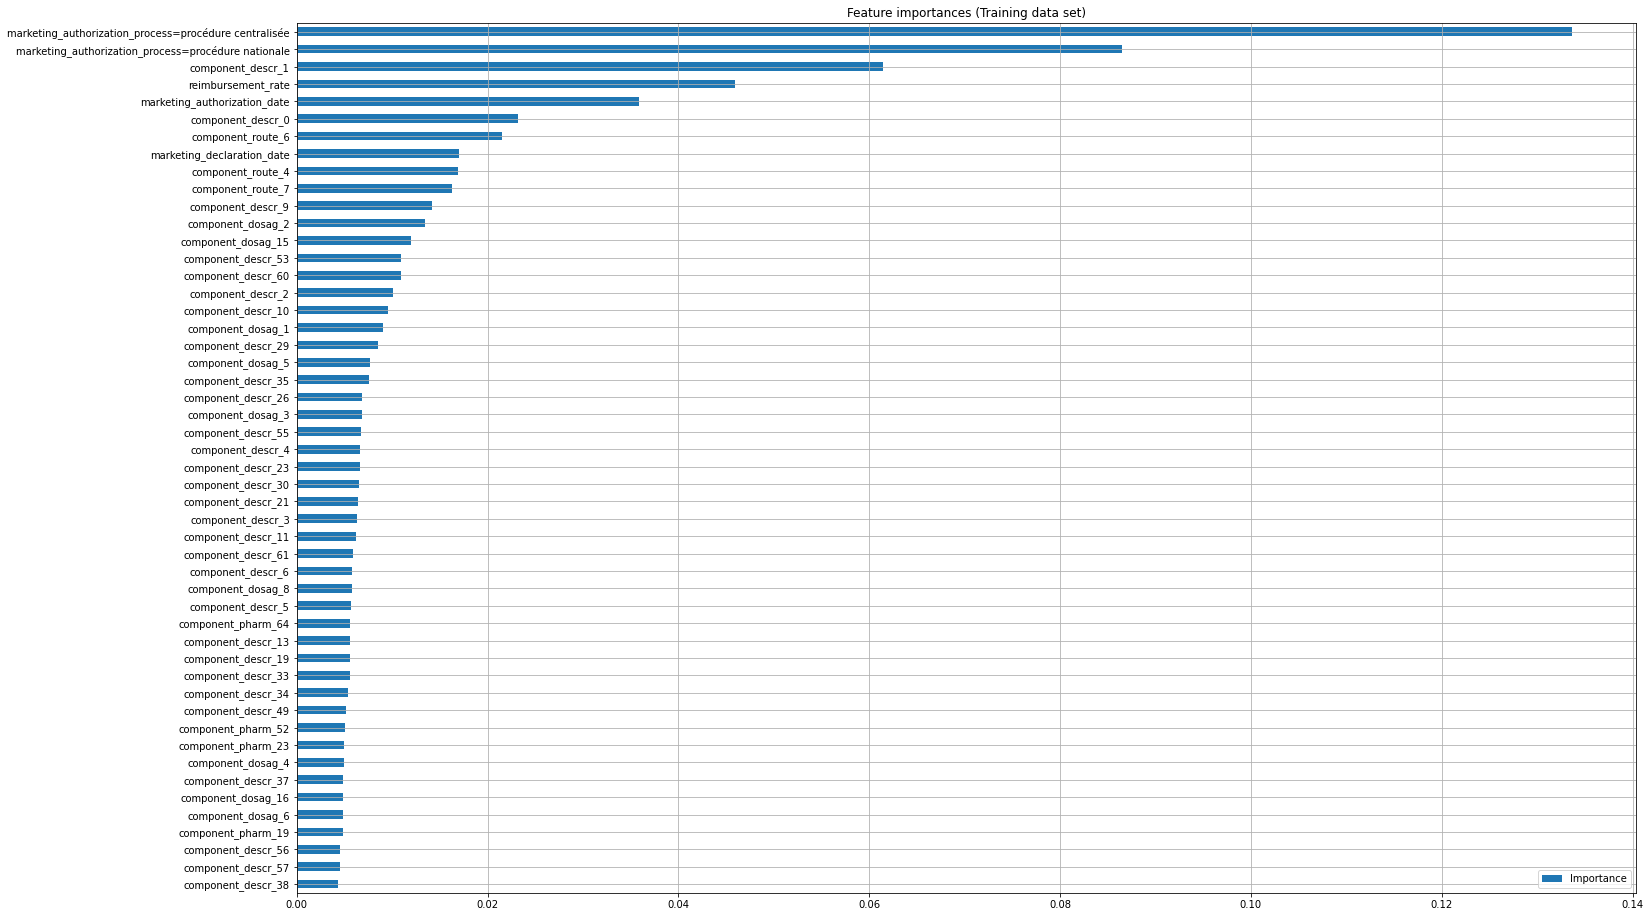

In [294]:
importance_df = pd.DataFrame(clf.feature_importances_, columns=["Importance"], index=list(FEATURES)).sort_values(['Importance'], ascending = True)
importance_df = importance_df.iloc[-50:]   # shows the 50 most important predictors
importance_df.plot(kind='barh', title ="Feature importances (Training data set)", grid=True, figsize=(24, 16))

## Predictions

In [295]:
parametersRF_opt = {
              'n_estimators': 1000, 
              'n_jobs': -1, 
              'verbose': 0, 
              'max_features': None,      
              'min_samples_leaf': 1   
             }  

In [ ]:
#clf = RandomForestRegressor(**parametersRF_opt)

# On entraine de nouveau le modèle, cette fois sur l'intégralité des données du training set
#y = train_df['logprice'].values
#X = train_df[FEATURES].values
#clf.fit(X, y)

# Puis on calcule les predictions sur le TEST dataset:
FEATURES_TEST = FEATURES
X_final_test = test[FEATURES_TEST].values
predictions = np.exp(clf.predict(X_final_test))

In [296]:
test_df.head()

,description,administrative_status,approved_for_hospital_use,reimbursement_rate,dosage_form,route_of_administration,marketing_declaration_date,marketing_authorization_date,pharmaceutical_companies,marketing_authorization_process=autorisation d'importation parallèle,...,component_pharm_76,component_pharm_77,component_route_0,component_route_1,component_route_2,component_route_3,component_route_4,component_route_5,component_route_6,component_route_7
0,plaquette(s) thermoformée(s) polyamide alumin...,1,0,5,comprimé gastro-résistant(e),orale,2013,2008,teva sante,0,...,0.006386,-0.005316,-0.478547,-0.029088,-0.040520,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
1,plaquette(s) thermoformée(s) pvc pvdc alumini...,1,0,2,capsule,vaginale,2012,1997,innotech international,0,...,-0.149625,-0.095337,1.687789,0.650202,1.426045,1.117363,-0.888117,0.110101,0.507048,1.076298
2,plaquette(s) thermoformée(s) pvc-aluminium de...,1,0,5,comprimé,orale,2013,2006,actavis france,0,...,-1.323393,-1.162783,-0.478547,-0.029088,-0.040520,-0.018683,0.011735,-0.001166,-0.004996,-0.008965
3,5 cartouche(s) en verre de 3 ml dans stylo pre...,1,0,5,suspension injectable,sous-cutanée,2012,2000,sanofi aventis (allemagne),0,...,-1.123899,-0.828920,2.360882,-3.246807,-0.808033,-0.495846,0.435127,-0.050756,-3.399192,1.594346
4,5 poche(s) à 3 compartiments polyamide polypr...,1,1,5,émulsion pour perfusion,intraveineuse,2011,2011,b braun melsungen,0,...,-1.346958,0.672600,2.175258,3.406354,-2.964611,-1.664459,-0.782248,-0.027508,0.101716,-1.508835
